# Create Plots and Visualizations for Manuscript

1. Preliminary Analyis 
2. BO Runtime Distribution Histogram
3. Search Efficiency Curves
    1. MFBO
    2. Comparison of MFBO, SFBO, and Random Search 
    3. Search traces for ensemble of MFBO, SFBO, and Random Search 
4. PCA Acquisition Dynamics
5. Feature Radar Plots 
6. Feature Correlation Plots

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.text as mpltxt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
###
#  figure settings 
###
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality
save_plots = False

figs_for_gif = False

<Figure size 640x480 with 0 Axes>

In [3]:
pal = sns.color_palette('Set2')
colors = [pal[4], pal[1]]
fid_to_color = {"high": pal[1], "low": pal[4]}
algo_to_color = {"SFBO": pal[3], "MFBO": pal[2], "random": pal[5]}

In [4]:
pal

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

## Load Data

In [5]:
# fideltiy values
lf_val = 1/3 # low-fidelity
hf_val = 2/3 # high-fidelity

In [6]:
###
#  construct a single dictionary from those of all the runs
###
def get_bo_res(which_results: str, nb_run: int):
    assert "results" in which_results
    # initialize dict to store results 
    bo_res = pickle.load(
             open('../search_results/{}/{}_run_{}.pkl'.format(which_results, 
                                                              which_results, 0), 'rb'))
    for key in bo_res.keys():
        bo_res[key] = []
        
    # iterate though the runs
    for n in range(nb_run):
        # get results dict for specified run
        bo_res_file = pickle.load(
                      open('../search_results/{}/{}_run_{}.pkl'.format(which_results, 
                                                                      which_results, n), 'rb'))
        
        # append results to end of list
        for key in bo_res_file.keys():
            key_res = bo_res_file[key]
            bo_res[key].append(key_res)
            
    return bo_res

In [7]:
###
#  features and molecular simulation data
###
file = h5py.File("../run_BO/targets_and_normalized_features.jld2", "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) 

# simulation data (targets)
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]  

# associated simulation costs
cost = [np.transpose(file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(file["gcmc_elapsed_time"][:])]        # [min]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  Bayesian optimization data
###
# COF IDs used for initialization
init_cof_ids_file = pickle.load(open('../search_results/initializing_cof_ids_normalized.pkl', 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']

nb_COFs_initialization = len(init_cof_ids[0])
nb_runs = len(init_cof_ids)

# random search 
random_search_res = pickle.load(open('../search_results/random_search_results.pkl', 'rb'))

# multi-fidelity search
mfbo_res = get_bo_res('mfbo_results', nb_runs)

# single-fideliy search
sfbo_res = get_bo_res('sfbo_results', nb_runs)

# number of iterations per run
nb_iters = len(mfbo_res['acquired_set'][0])

###
#  quick checks
###
# structure of data
assert len(sfbo_res['ids_acquired'][0]) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_COFs # nb_iterations
assert sfbo_res['nb_COFs_initialization'][0] == nb_COFs_initialization

# each run has the correct initializing COFs
assert all([all(sfbo_res['ids_acquired'][r][:nb_COFs_initialization] == init_cof_ids[r]) 
            for r in range(nb_runs)])

## Preliminary Analysis

In [8]:
# the max number of iterations needed for any of the runs
max_SFBO_iters = max(sfbo_res['BO_iter_top_cof_acquired'])
max_MFBO_iters = max(mfbo_res['BO_iter_top_cof_acquired'])

# the highest accumulated cost up to the max number of iterations needed
max_SFBO_cost = np.max(sfbo_res['accumulated_cost'][:][:max_SFBO_iters+1])
max_MFBO_cost = np.max(mfbo_res['accumulated_cost'][:][:max_MFBO_iters+1])


print("The max number of iterations needed for any of the runs -")
print("\tSFBO: {}".format(max_SFBO_iters))
print("\tMFBO: {}".format(max_MFBO_iters))
print("The highest accumulated cost up to the max number of iterations needed -")
print("\tSFBO: {} [hr]".format(max_SFBO_cost))
print("\tMFBO: {} [hr]".format(max_MFBO_cost))

The max number of iterations needed for any of the runs -
	SFBO: 101
	MFBO: 125
The highest accumulated cost up to the max number of iterations needed -
	SFBO: 704.8861669608626 [hr]
	MFBO: 345.67138266397825 [hr]


In [9]:
###
#  cost of doing an exhaustive low-fidelity search 
#  and itteraing down the list with high-fidelity simulations
#  until you simulate the Top COF.
###
total_lf_cost = sum(cost[0]) / 60 # [hr]
# sort COFs by selectivity in decenting order
lf_y_sorted = y[0].argsort()[::-1]
# get index of high-fidelity Top COF
hf_top_cof_id =  np.where(lf_y_sorted == np.argmax(y[1]))[0].item()
# add in the high-fidelity cost
lf_exhaustive_search_cost = total_lf_cost + (sum(cost[1][lf_y_sorted[:hf_top_cof_id+1]]) / 60) # [hr]
print("low-fidelity exhaustive search cost = ", lf_exhaustive_search_cost, " [hr]")

low-fidelity exhaustive search cost =  189.32410748448632  [hr]


In [10]:
###
#  cost of SFBO to find Top COF
#  initialized with max diverse set
###
sfbo_res['BO_iter_top_cof_acquired'][0] # 87
sfbo_res['ids_acquired'][0][87] # 375
cost[1][375] / 60 # 16.71 [hrs], hf cost of TOP COF
sfbo_cost = sum(sfbo_res['cost_acquired'][0][:sfbo_res['BO_iter_top_cof_acquired'][0]+1]) / 60 # [hr]
print("cost of SFBO search to find Top COF: " , sfbo_cost, " hrs")

cost of SFBO search to find Top COF:  314.9184591303931  hrs


In [11]:
# total hf cost of 
mfbo_top_cof_id = mfbo_res['BO_iter_top_cof_acquired'][0] # 47
mfbo_res['accumulated_cost'][0][mfbo_top_cof_id] # [hrs], 57.8
print("cost of MFBO search to find Top COF: " , mfbo_res['accumulated_cost'][0][mfbo_top_cof_id], " hrs")

# How much does the MFBO cost compare to the SFBO cost?
ratio_mfbo_sfbo = mfbo_res['accumulated_cost'][0][mfbo_top_cof_id] / sfbo_cost
print("cost ratio of MFBO to SFBO search: ", ratio_mfbo_sfbo)

# How much does the MFBO cost compared to a high-fidelity exhaustive search?
gcmc_exhaustive_search_cost = sum(cost[1]) / 60 # [hrs], exhaustive high-fidelity search
ratio_mfbo_exh = mfbo_res['accumulated_cost'][0][mfbo_top_cof_id] / gcmc_exhaustive_search_cost
print("cost ratio of MFBO to GCMC exhaustive search: ", ratio_mfbo_exh)

# How much of the MFBO search cost is due to high-fidelity evalutations?
where_fids = np.where([mfbo_res['acquired_set'][0][:, 0] == 2/3])
mfbo_hf_fraction = sum(mfbo_res['cost_acquired'][0][where_fids[1][:9]]) / 60 # [hrs]
mfbo_hf_fraction /= mfbo_res['accumulated_cost'][0][mfbo_top_cof_id]
print("proportion of high-fidelity cost in MFBO search: ", mfbo_hf_fraction)

cost of MFBO search to find Top COF:  57.80021943906943  hrs
cost ratio of MFBO to SFBO search:  0.18354027134096018
cost ratio of MFBO to GCMC exhaustive search:  0.024791415560779052
proportion of high-fidelity cost in MFBO search:  0.8431362615270684


# Plot Search Results 

In [12]:
###
#  get the distribution (mean, std) of an ensemble of searches
###
def get_distribution(res, maxes=False):
    # initialize arrays for dist.
    mu      = np.zeros(nb_iters)
    sig_bot = np.zeros(nb_iters)
    sig_top = np.zeros(nb_iters)
    
    ###
    #  look at all runs and get the dist.
    ###
    for i in range(1, nb_iters+1):
        if maxes:
            # max value acquired up to this point (over all runs)       
            vals_at_iter = np.array([max(res[r][:i]) for r in range(nb_runs)])
        else:
            # make an arrey of all the values at a given iteration
            vals_at_iter = np.array([res[r][i-1] for r in range(nb_runs)])
        assert np.size(vals_at_iter) == nb_runs
        mu[i-1]      = np.mean(vals_at_iter)
        sig_bot[i-1] = np.std(vals_at_iter[vals_at_iter < mu[i-1]])
        sig_top[i-1] = np.std(vals_at_iter[vals_at_iter > mu[i-1]])
        
    return  mu, sig_bot, sig_top

In [13]:
###
#  when, on average, is the top COF located? 
###
mfbo_mean_iter_top_cof = int(np.round(np.mean(mfbo_res['BO_iter_top_cof_acquired'])))
sfbo_mean_iter_top_cof = int(np.round(np.mean(sfbo_res['BO_iter_top_cof_acquired'])))

print("Average iterations to locate top COF - ")
print("MFBO:\t", mfbo_mean_iter_top_cof)
print("SFBO:\t", sfbo_mean_iter_top_cof)

Average iterations to locate top COF - 
MFBO:	 48
SFBO:	 76


### BO Ruuntime Distribution Histogram

SFBO  max search time =  456.2303129938576
SFBO  avg search time =  260.8919535738408
MFBO  max search time =  169.97261515571014
MFBO  avg search time =  57.55046238002049


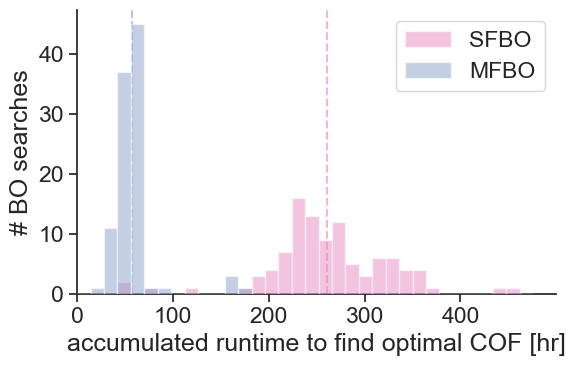

In [14]:
###
#  make a histogram of the distribution of accumulated cost 
###
fig = plt.figure(figsize=(6, 4))
width = 14
bins = np.array([int(width*i) for i in range(int(500 / width))])

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    x = []
    # color
    color = algo_to_color[search_type]
    
    for r in range(nb_runs):
        n = res['BO_iter_top_cof_acquired'][r]
        x.append(res['accumulated_cost'][r][n])
    
    print(search_type, " max search time = ", np.max(x))
    print(search_type, " avg search time = ", np.mean(x))
    plt.axvline(x=np.mean(x), color=color, linestyle="--", lw=1.5, alpha=0.6)
    plt.hist(x, bins, label=search_type, color=color, alpha=0.5, zorder=10)


###
#  axis settings
###
plt.xlim(xmin=0)
plt.xlabel('accumulated runtime to find optimal COF [hr]')
plt.ylabel('# BO searches')
plt.legend()

sns.despine()
plt.tight_layout()
if save_plots:
    plt.savefig("./hist_accumulated_cost_destribution.pdf", format="pdf")
plt.show()

## Search Efficientcy Curves

In [15]:
### 
#  get the maximum selectivity from a running list
###
def get_y_maxes_acquired(y_acquired):
    nb_iters = len(y_acquired)
    return [max(y_acquired[:i+1]) for i in range(nb_iters)]  

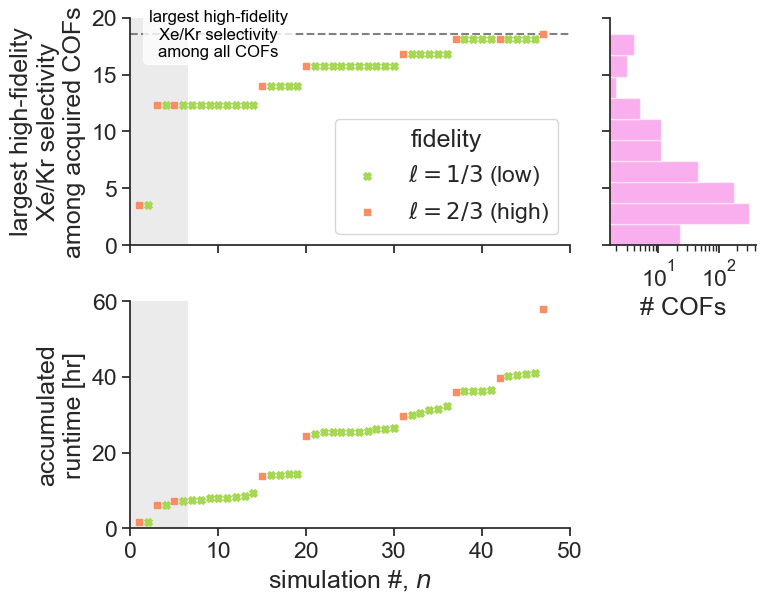

In [17]:
fid_to_marker = {"low": "x", "high": "s"}
ms = 22

###
#  define constants useful for plotting
###
iter_start = 2 * nb_COFs_initialization
iter_top_cof_acquired = mfbo_res['BO_iter_top_cof_acquired'][0] 
iter_range = np.array(range(nb_iters)) 


_fids = mfbo_res['acquired_set'][0][:, 0]
mfbo_ymax_acq = mfbo_res['y_max_acquired'][0][:iter_top_cof_acquired+1]
mfbo_acc_cost = mfbo_res['accumulated_cost'][0][:iter_top_cof_acquired+1]

###
#  plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [4, 4]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(8, 7))



###
#  search efficiency vs accumulated cost
#  include scatter for search start and stop
###
ax[0,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == lf_val)[0][1:], 
                mfbo_ymax_acq[_fids[:iter_top_cof_acquired+1] == lf_val][1:],    
                label=r"$\ell=1/3$ (low)",
                ec=fid_to_color["low"], marker=fid_to_marker["low"], s=ms, zorder=10) 

ax[0,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == hf_val)[0], 
                mfbo_ymax_acq[_fids[:iter_top_cof_acquired+1] == hf_val],   
                label=r"$\ell=2/3$ (high)",
                ec=fid_to_color["high"], marker=fid_to_marker["high"], s=ms, zorder=10)

ax[0,0].axvspan(0, iter_start+0.5, color='C7', alpha=0.25, lw=0)

plt.setp(ax[0,0].get_xticklabels(), visible=False) # remove yticklabels


###  
#  global maximum
###
ax[0,0].axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
ax[0,0].text(10.0, max(y[1]), 
             "largest high-fidelity\nXe/Kr selectivity\namong all COFs",
          # r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
           color="black", fontsize=12, ha="center", va="center",
           bbox=dict(boxstyle="round",
               ec=(1., 1., 1., 0.8),
               fc=(1., 1., 1., 0.8),
               )
         )


###
#  histogram of selectivities
###
hist_cbar = sns.color_palette("husl", 8)
ax[0,1].hist(y[1], color=hist_cbar[7], alpha=0.5, orientation='horizontal')
ax[0,1].sharey(ax[0,0])
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('# COFs')
plt.setp(ax[0,1].get_yticklabels(), visible=False) # remove yticklabels


###
#  Accumulated cost
###
ax[1,0].sharex(ax[0,0])


ax[1,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == lf_val)[0][1:], 
                mfbo_acc_cost[_fids[:iter_top_cof_acquired+1] == lf_val][1:], 
                marker=fid_to_marker["low"], ec=fid_to_color["low"], s=ms, zorder=10) # fc="none",

ax[1,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == hf_val)[0], 
                mfbo_acc_cost[_fids[:iter_top_cof_acquired+1] == hf_val], 
                marker=fid_to_marker["high"], ec=fid_to_color["high"], s=ms, zorder=10)

ax[1,0].axvspan(0, iter_start + 0.5, color='C7', alpha=0.25, lw=0)

ax[1,0].set_ylim(ymin=-0, ymax=60)
ax[1,0].set_xlabel('simulation #, $n$')
ax[1,0].set_ylabel("accumulated\nruntime [hr]")
# plt.setp(ax[1,0].get_xticklabels(), visible=False) # remove yticklabels


###
#  remove extra axis
###
plt.delaxes(ax[1,1])

###
#  axis settings
###
# search efficiency 
ax[0,0].set_xlim(xmin=-0, xmax=50)
ax[0,0].set_ylim(ymin=0, ymax=20)
ax[0,0].set_ylabel("largest high-fidelity\nXe/Kr selectivity\namong acquired COFs")
    #r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')
ax[0,0].legend(title="fidelity", loc=4, ncol=1)
plt.subplots_adjust(hspace=-12, wspace=0)
plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./MFBO_multipanel.pdf", bbox_inches="tight", format="pdf")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))  
# markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = algo_to_color[search_type]
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = res['BO_iter_top_cof_acquired'][0]
    print(iter_top_cof_acquired)
    print(res['accumulated_cost'][0][iter_top_cof_acquired])
    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  search efficiency vs accumulated cost
    ###
    plt.plot(res['accumulated_cost'][0][iter_start:iter_top_cof_acquired + 1], 
             res['y_max_acquired'][0][iter_start:iter_top_cof_acquired + 1],    
             label=search_type, 
             color=color, zorder=10)

    # start and stop
    plt.scatter([res['accumulated_cost'][0][iter_start]], 
                [res['y_max_acquired'][0][iter_start]],  
                color=color, marker="o", zorder=100)
    
    plt.scatter([res['accumulated_cost'][0][iter_top_cof_acquired]], 
                res['y_max_acquired'][0][iter_top_cof_acquired+1],  
                color=color, marker="s", zorder=100)
    

###
#  random search (high-fidelity, l=1)
###
iter_stop = np.max(mfbo_res['BO_iter_top_cof_acquired']) + 1
# accumulated cost
acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])

plt.plot(acc_cost_mu[:iter_stop], 
         random_search_res['y_rs_max_mu'][:iter_stop], 
         label="random", color=algo_to_color["random"], zorder=2)

plt.fill_between(acc_cost_mu[:iter_stop], 
                 random_search_res['y_rs_max_mu'][:iter_stop] - 
                 random_search_res['y_rs_max_sig_bot'][:iter_stop], 
                 random_search_res['y_rs_max_mu'][:iter_stop] + 
                 random_search_res['y_rs_max_sig_top'][:iter_stop], 
                 alpha=0.25, color=algo_to_color["random"], zorder=1)

# start and stop
plt.scatter([acc_cost_mu[0]], [random_search_res['y_rs_max_mu'][0]],
            color=algo_to_color["random"], marker="o", zorder=100)

# plt.scatter([acc_cost_mu[iter_stop-1]], [random_search_res['y_rs_max_mu'][iter_stop-1]],   
#             color="C2", marker="s", zorder=100)

###  
#  global maximum
###
plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
plt.text(150.0, max(y[1]) + 0.25, 
         "largest high-fidelity\nXe/Kr selectivity\namong all COFs", fontsize=12,
            bbox=dict(boxstyle="round",
               ec=(1., 1., 1., 0.8),
               fc=(1., 1., 1., 0.8),
               ),
         ha="center",
          # r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
           color="black")

###
#  axis settings
###
# search efficiency 
plt.xlim(xmin=0, xmax=350)
plt.ylim(ymin=0)
plt.xlabel("accumulated runtime [hr]")
plt.ylabel("largest high-fidelity\nXe/Kr selectivity\namong acquired COFs")
           #r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')

# dummy plots for legend
p_empty_cir = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = plt.plot([], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')

plt.legend(loc=4, ncol=2, fontsize=13)



plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./AccCost_vs_SearchEfficiency.pdf", format="pdf")
plt.show()

### Plot Search Traces

In [ ]:
fig = plt.figure(figsize=(8, 6))

# loop over search types
for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = algo_to_color[search_type]

    # loop over search results
    for j in range(len(res['y_max_acquired'])):
        # zorder
        z = np.random.randint(100)
        # important indexes
        iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
        iter_top_cof_acquired = res['BO_iter_top_cof_acquired'][j]   
        iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
        ###
        #  search efficiency vs accumulated cost
        ###
        plt.plot(res['accumulated_cost'][j][iter_start:iter_top_cof_acquired + 1], 
                res['y_max_acquired'][j][iter_start:iter_top_cof_acquired + 1],    
                color=color, zorder=z, alpha=0.25)

        # start and stop
        plt.scatter([res['accumulated_cost'][j][iter_start]], 
                    [res['y_max_acquired'][j][iter_start]],  
                    fc="none", ec=color, marker="o", lw=1.5, zorder=z)
        
        plt.scatter([res['accumulated_cost'][j][iter_top_cof_acquired]], 
                    res['y_max_acquired'][j][iter_top_cof_acquired+1],  
                    fc="none", ec=color, marker="s", lw=1.5, zorder=z)


###
#  random search traces
###
rs_ids_acquired = np.random.choice(range(len(random_search_res['ids_acquired'])), replace=False, size=100)
# track how many of these runs find the Top COF
rs_acquired_top_cof = 0
# loop over selected runs
for i, rs_search_id in enumerate(rs_ids_acquired):
    z = np.random.randint(100)
    rs_ids = random_search_res['ids_acquired'][rs_search_id]
    rs_y_maxes = get_y_maxes_acquired(y[1][rs_ids.tolist()].tolist())
    acq_top_cof = False
    if np.argmax(y[1]) in rs_ids:
        iter_stop = np.argmax(rs_y_maxes)
        acq_top_cof = True
        rs_acquired_top_cof += 1
    else:
        iter_stop = len(rs_y_maxes)
    # in the event that the top COF is the initial entry
    if iter_stop == 0:
        iter_stop = 1

    plt.plot(random_search_res['accumulated_cost'][rs_search_id].tolist()[:iter_stop], 
             rs_y_maxes[:iter_stop], 
             color=algo_to_color["random"], alpha=0.1, zorder=z)
    
    # start and stop
    plt.scatter([random_search_res['accumulated_cost'][rs_search_id].tolist()[0]], 
                [rs_y_maxes[0]],  
                fc="none", ec=algo_to_color["random"], marker="o", lw=1.5, zorder=z)
    
    if acq_top_cof:
        plt.scatter([random_search_res['accumulated_cost'][rs_search_id].tolist()[iter_stop]], 
                    [rs_y_maxes[iter_stop]],  
                    fc="none", ec=algo_to_color["random"], marker="s", lw=1.5, zorder=z)

print(rs_acquired_top_cof)

###  
#  global maximum
###
plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
plt.text(200.0, max(y[1]) + 0.4, 
         "largest high-fidelity Xe/Kr selectivity among all COFs",
          # r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
           color="gray", fontsize=12)

###
#  axis settings
###
# search efficiency 
plt.xlim(xmin=0, xmax=750)
plt.ylim(ymin=0)
plt.xlabel("accumulated runtime [hr]")
plt.ylabel("largest high-fidelity\nXe/Kr selectivity\namong acquired COFs")
    #r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')

###
#  dummy plots for legend labels
###
plt.plot([], [], label='SFBO', color=algo_to_color["SFBO"])
plt.plot([], [], label='MFBO', color=algo_to_color["MFBO"])
plt.plot([], [], label='random', color=algo_to_color["random"])
p_empty_cir = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = plt.plot([], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')

plt.legend(loc=4, ncol=2)



plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./AccCost_vs_SearchEfficiency_AllRuns.pdf", format="pdf")
plt.show()

# Pirinciple Component Analysis

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

###
#  test point
###
a = torch.from_numpy(np.array([X[:, i].mean() for i in range(X.size()[1])]))
X_center = pca.transform(a.reshape(1, -1))

In [ ]:
cmap_name = cm.summer_r # sequential colormap (reversed)

###
#  low dimensional (PCA) visualization of the entire dataset
###
fig = plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

###
#  axis commands
###
ax_lim = max([np.max(X_2D), abs(np.min(X_2D))]) + 0.2
plt.xlim([-ax_lim, ax_lim])
plt.ylim([-ax_lim, ax_lim])

plt.xticks()
plt.yticks()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$y^{(\ell=2/3)}_{Xe/Kr}$")

plt.gca().set_aspect('equal', 'box')

plt.tight_layout()
if save_plots:
    plt.savefig("./PCA_feature_space_colored_by_GCMC_Selectivity.pdf", format="pdf")
plt.show()

In [ ]:
nb = 6
acq = mfbo_res['acquired_set'][0][:nb]
lf_acq = acq[acq[:, 0] == lf_val, :] # low-fidelity
lf_acq[:nb, 1].astype(int)

In [ ]:
hf_acq = acq[acq[:, 0] == hf_val, :] # high-fidelity
hf_acq

In [ ]:
panel_step = np.ceil((mfbo_res['BO_iter_top_cof_acquired'][0] - 2*nb_COFs_initialization) / 5)

nb_acquired = [2*nb_COFs_initialization + i*int(panel_step) for i in range(6)]

nb_acquired[len(nb_acquired) - 1] = mfbo_res['BO_iter_top_cof_acquired'][0] + 1 # have to adjust the indexing

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8*2 + 0.5])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2, 3),
                 axes_pad=0.2,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][0][:nb]
    lf_acq = acq[acq[:, 0] == lf_val, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == hf_val, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)

    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=15, alpha=0.8) 
    

    ###
    #  indicate top COF
    #  arrow is drawn from (x, y) to (x+dx, y+dy)
    ###
    top_cof_id = np.argmax(y[1])
    eps = 0.12
    ax.arrow(X_2D[top_cof_id, 0]-eps, X_2D[top_cof_id, 1]+eps, eps*0.7, -eps*0.7,
             head_width=0.025, color='k', alpha=0.6)
    ax.text(X_2D[top_cof_id, 0]-3.95*eps, X_2D[top_cof_id, 1]+1.2*eps, 'optimal\n   COF', color="grey")

    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1].astype(int), 0], X_2D[lf_acq[:nb, 1].astype(int), 1], 
                  label="$\ell=1/3$ (low-fidelity)",
                  color='k', marker='x', s=35, lw=0.45, zorder=2) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1].astype(int), 0], X_2D[hf_acq[:nb, 1].astype(int), 1], 
               label="$\ell=2/3$ (high-fidelity)",
               fc='none', ec='k', marker='s', s=40, lw=0.5, zorder=10)
    

    
    # subplot titles --- use ax.text 
    if i == 0:
        ax.set_title('(initialization)')
    ax.text(0.5, 1.0, '$n=${} simulations'.format(nb_acquired[i]), ha='center')
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
# cb.set_label(label="$y^{(\ell=2/3)}_{Xe/Kr}$", fontsize=24)
cb.set_label(label="high-fidelity Xe/Kr selectivity", fontsize=24)

###
#  axis commands
###
grid[0].legend(loc=(0.013, 0.013))
fig.text(0.155, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
fig.text(0.52, 0.05, 'principal component 1', ha='center', fontsize=24)

grid[0].set_xlim([-ax_lim, ax_lim])
grid[0].set_ylim([-ax_lim, ax_lim])


if save_plots:
    plt.savefig("./MFBO_PCA_dynamics.pdf", bbox_inches="tight", format="pdf")
plt.show()

### make PCA figs to compile into a GIF.

In [ ]:
if figs_for_gif:
    iter_stop = mfbo_res['BO_iter_top_cof_acquired'][0] - 2*nb_COFs_initialization

    nb_acquired = [2*nb_COFs_initialization + i for i in range(iter_stop)]

    nb_acquired[len(nb_acquired) - 1] = mfbo_res['BO_iter_top_cof_acquired'][0] + 1 # have to adjust the indexing



    # add data to image grid
    for (i, nb) in enumerate(nb_acquired):
        acq = mfbo_res['acquired_set'][0][:nb]
        lf_acq = acq[acq[:, 0] == lf_val, :] # low-fidelity
        hf_acq = acq[acq[:, 0] == hf_val, :] # high-fidelity
        assert len(lf_acq) + len(hf_acq) == len(acq)

        ###
        #  figure
        ###
        fig = plt.figure(figsize=(6, 6), dpi=300)
        cmap_name = cm.summer_r # sequential colormap (reversed)
        grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1, 1),
                    axes_pad=0.2,
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.15,
                    )

        ax = grid[0]
        ###
        #  plot PCA for all COFs
        ###
        pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                                facecolor='none', s=15, alpha=0.8) 
        

        ###
        #  indicate top COF
        #  arrow is drawn from (x, y) to (x+dx, y+dy)
        ###
        top_cof_id = np.argmax(y[1])
        eps = 0.12
        ax.arrow(X_2D[top_cof_id, 0]-eps, X_2D[top_cof_id, 1]+eps, eps*0.7, -eps*0.7,
                head_width=0.025, color='k', alpha=0.6)
        ax.text(X_2D[top_cof_id, 0]-3.95*eps, X_2D[top_cof_id, 1]+1.2*eps, 'optimal\n   COF', color="grey")

        ###
        #  indicate acquired points at the given iteration
        ###
        # low-fidelity
        ax.scatter(X_2D[lf_acq[:nb, 1].astype(int), 0], X_2D[lf_acq[:nb, 1].astype(int), 1], 
                    label="$\ell=1/3$ (low-fidelity)",
                    color='k', marker='x', s=35, lw=0.45, zorder=2) 
        # high-fidelity
        ax.scatter(X_2D[hf_acq[:nb, 1].astype(int), 0], X_2D[hf_acq[:nb, 1].astype(int), 1], 
                label="$\ell=2/3$ (high-fidelity)",
                fc='none', ec='k', marker='s', s=40, lw=0.5, zorder=10)

        # subplot titles --- use ax.text 
        if i == 0:
            ax.text(0.1, 1.0, '(initialization) {} experiments'.format(nb_acquired[i]), ha='center')
            # ax.text('(initialization)')
        else:
            ax.text(0.5, 1.0, '{} experiments'.format(nb_acquired[i]), ha='center')
            
        ax.tick_params(axis='x')
        ax.set_aspect('equal', 'box')

        ###
        #  colorbar
        ###
        cb = ax.cax.colorbar(pca_base)
        # cb.set_label(label="$y^{(\ell=2/3)}_{Xe/Kr}$", fontsize=24)
        cb.set_label(label="high-fidelity Xe/Kr\nselectivity", fontsize=24)

        

        ###
        #  axis commands
        ###
        grid[0].legend(loc=(0.013, 0.013))
        # fig.text(0.155, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
        fig.text(-0.025, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
        # fig.text(0.52, 0.05, 'principal component 1', ha='center', fontsize=24)
        fig.text(0.52, 0.035, 'principal component 1', ha='center', fontsize=24)

        grid[0].set_xlim([-ax_lim, ax_lim])
        grid[0].set_ylim([-ax_lim, ax_lim])

        if save_plots:
            plt.savefig("./pca_dynamics/MFBO_PCA_dynamics_{}.png".format(i), bbox_inches="tight", format="png")
        plt.show()


# Radar Plot of Feature Vector

custom scale on each axis adapted from code [here](https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart)

In [ ]:
###
#  load data
###
cof_file = h5py.File("top_COF_feature_vector.jld2", "r")
values = np.array(cof_file['features']).tolist() # has 14 entries
print("Top COF ID = ", top_cof_id)
print("Top COF feature vector:\n", values)

# descriptors
property_type = ['geometric', 'chemical']
descriptors = []

for prop in property_type:
    filename = "../descriptors/{}_properties.csv".format(prop)
    df = pd.read_csv(filename)
    for descriptor in df.columns:
        if descriptor != "crystal_name": 
            descriptors.append(descriptor)
            
###
#  fix labels for plotting
###
pretty_des_names = dict({'pore_diameter_Å': 'pore\ndiameter [Å]', 
                         'void_fraction': 'void fraction',
                         'surface_area_m²g⁻¹': 'surface area [m² g⁻¹]',
                         'crystal_density': 'crystal density [kg m⁻³]'
                        })

for n, des in enumerate(descriptors):
    if des in pretty_des_names.keys():
        descriptors[n] = pretty_des_names[des] + ''
    else:
        descriptors[n] = descriptors[n] + ""
        
print("feature labels: \n", descriptors)

In [ ]:
def _scale_data(data, ranges):
    """scales data[1:] to ranges[0]"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    sdata = [data[0]] 
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, n_ordinate_levels=6):
        # divide circle into equal parts
        angles = np.arange(0, 360, 360./len(variables))
        
        # make a list of the axes (one per dscriptor variable)
        # [0.1, 0.1, 0.9, 0.9]
        axes = [fig.add_axes([0.0, 0.0, 1.0, 1.0], polar=True, label="axes{}".format(i)) 
                for i in range(len(variables))]
        
        # put variable name at the correct angle
        # adjust rotation of text for readability
        l, text = axes[0].set_thetagrids(angles, labels=variables, fontsize=26)
        [txt.set_rotation(angle-90) for txt, angle in zip(text, angles)] 
        
        # overlay each axis
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off", lw=1)
            ax.xaxis.set_visible(False)
            
        # specify grid labels
        for i, ax in enumerate(axes): 
            # ax.set_axisbelow(False)
            ax.yaxis.set_zorder(0)

            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            gridlabel = [] #["{0:.2f}".format(round(x, 2)) for x in grid]
            for j, x in enumerate(grid):
                if j == 0 or j == len(grid)-1:
                    gridlabel.append("{0:.1f}".format(round(x, 2)))
                else:
                    gridlabel.append('')
            
            gridlabel[0] = "" # clean up origin

            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[i], fontsize=20, color='grey') 
            
            ###
            #  Go through labels and adjust alignment based on where
            #  it is in the circle.
            ###
            for label in labels:
                if angles[i] == 0:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('bottom')
                elif 0 < angles[i] < 55:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('top')
                elif 55 <= angles[i] < 90:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('top')
                elif 90 <= angles[i] < 180:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('top')
                elif angles[i] == 180.0:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 180 < angles[i] < 225:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 225 <=  angles[i] < 270:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 270 <=  angles[i] < 300:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('bottom')
                elif 300 <= angles[i]:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('baseline')
            
            # if i == 0:
            #     ax.set_zorder(10)
            # else:
            #     ax.set_zorder(10)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        
        ###    
        #  variables for plotting
        ###
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

        
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        # put this one on top so gridlines don't overlap data
        self.ax.set_zorder(100)
        
        self.ax.spines["polar"].set_visible(True)

        ###
        #  Go through labels and adjust alignment based on where
        #  it is in the circle.
        ###
        for label, angle in zip(self.ax.get_xticklabels(), self.angle):
            ang = np.rad2deg(angle)
            if ang == 0:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center_baseline')
            elif 0 < ang < 90:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center_baseline')
            elif 55 <= ang < 90:
                label.set_horizontalalignment('right')
                label.set_verticalalignment('bottom')
            elif 90 <= ang < 180:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif ang == 180.0:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center')
            elif 180 < ang < 225:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif 225 <=  ang < 270:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif 270 <=  ang:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center')
        ###        
        #  make the pannel transparent so you can see the 
        #  plot labels below it
        ###
        self.ax.patch.set_alpha(0.0)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


In [ ]:
###
#  data
###
variables = tuple(descriptors)
data = tuple(values)
# ymax will be 10**(base) 
ranges = []
for val in values:
    if 0 <= val <= 1:
        base = 0
    else:
        base = int(np.ceil(np.log10(val)))
    ranges.append((0, 10**base))
    
###
#  plotting
###
fig1 = plt.figure(figsize=(8, 8)) 
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data, color='red', alpha=1.0, lw=3) 
# radar.fill(data, color='red', alpha=0.25)

if save_plots:
    plt.savefig("./top_COF_raw_feature_vector_radar.pdf", bbox_inches="tight", format='pdf')
plt.show()

### radar plot multiple cofs

In [ ]:
###
#  get COF ids 
###
num_at_performance = 15 # how many ids to get

# np.argsort() is in ascending order, so top COFs at the end of list
poor_performning_cofs = np.argsort(y[1])[:num_at_performance]
print("IDs of top performing COFs: ", poor_performning_cofs)

high_performing_cofs = np.argsort(y[1])[-num_at_performance:]
print("IDs of top performing COFs: ", high_performing_cofs)

# compile into a single list
cof_ids_to_include = [poor_performning_cofs, high_performing_cofs]
performing_cofs = np.array([item for sublist in cof_ids_to_include for item in sublist])


###
#  load in data
###
targets_and_features = h5py.File("targets_and_raw_features.jld2", "r")
# keys: ['X', 'gcmc_elapsed_time', 'gcmc_y', 'henry_total_elapsed_time', 'henry_y'
# targets_and_features.keys()
cof_feature_values = np.array(targets_and_features['X'])
print('shape of feature matrix: {}'.format(cof_feature_values.shape)) # (14, 608) => each featue is a 
# len(cof_feature_values[:, 0]) # 14, features for a given COF
# len(cof_feature_values[1])    # 608, given feature for all COFs


###
#  get feature vector for desired COFs
###
performing_cof_features = cof_feature_values[:, performing_cofs]


###
#  construct data for radar plot
###
variables = tuple(descriptors) # descriptors defined above
values = performing_cof_features
data = [tuple(v) for v in values.transpose()]
# len(data[0])

In [ ]:
###
#  get data ranges for grid
###
ranges = [(0, 0) for i in range(len(values))] 
for k, feature in enumerate(values):
    for val in feature:
        if 0 <= val <= 1:
            base = 0
        else: 
            base = int(np.ceil(np.log10(val)))

        if int(ranges[k][1]) <= 10**base:
            ranges[k] = tuple([0, 10**base])

print(ranges)

In [ ]:
##
#  plotting
###
cpl = sns.color_palette("hls", 8)
fig1 = plt.figure(figsize=(8, 8)) 
radar = ComplexRadar(fig1, variables, ranges)

# define a color set
bottom_c = sns.color_palette("husl", 8)[0]
top_c = sns.color_palette("husl", 8)[3]

for j, d in enumerate(data):
    if j < num_at_performance:
        color = bottom_c
    else:
        color = top_c
    radar.plot(d, color=color, alpha=0.45, lw=2) 
    # radar.fill(d, color=color, alpha=0.15)

###
#  dummy plots for legend labels
###
p_empty_sqr = plt.plot([], linestyle='-', label='top COFs', color=top_c, alpha=0.45)

p_empty_cir = plt.plot([], linestyle='-', label='bottom COFs', color=bottom_c, alpha=0.45)

plt.legend(loc=[1.05, 0.00], ncol=1, title='performance')

if save_plots:
    plt.savefig("./compare_COFs_raw_feature_vectors_radar.pdf", bbox_inches="tight", format='pdf')
plt.show()

# Plot Correlation of Features to Selectivity

In [ ]:
###
#  features and molecular simulation data
###
normalization = "normalized" 
raw_feature_file = h5py.File("targets_and_raw_features.jld2".format(normalization), "r")

# feature matrix
X_raw = torch.from_numpy(np.transpose(raw_feature_file["X"][:])) 

# simulation data
y_raw = [np.transpose(raw_feature_file["henry_y"][:]), 
     np.transpose(raw_feature_file["gcmc_y"][:])]  

# associated simulation costs
raw_cost = [np.transpose(raw_feature_file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(raw_feature_file["gcmc_elapsed_time"][:])]        # [min]

X_raw.shape
print("X_raw[i, :] - each row (i) is a COF")
print("X_raw[:, j] - each column (j) is a feature")
print("list of features:")
descriptors[0] = 'pore diameter [Å]' # need to clean up name
print(descriptors)

In [ ]:
# descriptors[0] = 'pore diameter [Å]' # need to clean up name

In [ ]:
# loop over the features and plot the correlatins
for i, des in enumerate(descriptors):
    lbl_fs = 24 # label fontsize
    if i > 3:
        lbl_fs = 36

    fig = plt.figure(figsize=(6,6))
    plt.scatter(X_raw[:, i], y_raw[1], fc="none", ec="C2")
    #  kinetic diameter of Kr (~3.60 Å) and Xe (~4.1 Å)
    if 'diameter' in des:
        # plt.axvline(x=3.60, label="Kr", color='k', lw=0.5, linestyle=":")
        plt.axvline(x=3.96, label="Xe 4.1 Å", color='k', lw=0.5, linestyle="--")
        plt.legend(title=r"Kinetic diameter", fontsize=20, title_fontsize=20)

    if des in ['B', 'O', 'C', 'H', 'Si', 'N', 'S', 'P', 'halogens', 'metals']:
        plt.xlabel("fraction " + des, fontsize=lbl_fs)
    else:
        plt.xlabel(des, fontsize=lbl_fs)

    plt.ylabel(r"$y^{(\ell=2/3)}(\mathbf{x})$", fontsize=lbl_fs)
    
    plt.xlim(xmin=0)
    if X_raw[:, i].max().item() < 1.1:
        plt.xlim(xmax=1.0)

    plt.ylim(ymin=0)

    plt.tight_layout()
    if save_plots:
        if ('[' in des):
            # remove units from filename
            nn = np.where(['[' in s for s in des.split()])[0].item()
            fig_name = des.split()[:nn]
        else:
            fig_name = des.split()
        
        plt.savefig("./feature_correlations/selectivity_vs_{}.pdf".format("_".join(fig_name)), format='pdf')
    plt.show()